<h1>Emotion Analysis - Part 1</h1>
<h2><i>Data Preparation and Emotion Analysis with Text-Classification Model</i></h2>

<h3>[Imports]</h3>

In [164]:
# Imports
import re
from importlib.resources.readers import remove_duplicates

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
from pandas.core.dtypes.common import infer_dtype_from_object
from datetime import datetime, timedelta
from plotly import hist_frame
style.use('ggplot')
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
import json
import torch
from transformers import pipeline
from tqdm import tqdm
from itertools import pairwise
import pytz
import matplotlib.ticker as ticker
from scipy import stats

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aklei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [165]:
RUN_TYPE = 0 # set to 1 to repeat file creation process

<h3>[Data Preparation]</h3>
<p>Normalizing the quoted_tweets-dictionary to create a dataframe that contains the text of the quoted and origional tweet.</p>

In [166]:
# Prepare dataframe for analysis
## Import dataset
df_tweets = pd.read_csv(
    '../data/twitter/tweets_isTweet.csv',
    dtype={'id': 'object'},
    low_memory=False
)
## Parameter for weighing emotions per event later in Event Study
df_tweets['total_engagement'] = (df_tweets['retweetCount'] +
                                 df_tweets['likeCount'] +
                                 df_tweets['replyCount'] +
                                 df_tweets['quoteCount'] +
                                 df_tweets['viewCount'])
df_tweets = df_tweets[['id', 'createdAt', 'text', 'quoted_tweet', 'total_engagement']]
df_tweets = df_tweets.rename(columns={'id': 'tweet_id', 'text': 'tweet_text'})

## Normalize json column
quoted_tweets_normalized = pd.json_normalize(
    df_tweets['quoted_tweet'].apply(
        lambda x: json.loads(x) if pd.notna(x) and isinstance(x, str) else None
    )
)
quoted_tweets_normalized = quoted_tweets_normalized.rename(columns={
    'id': 'quoted_tweet_id',
    'text': 'quoted_tweet_text'
})

## Link by index
df_tweets.index = quoted_tweets_normalized.index

## Concat both dataframes
df_tweets_normalized = pd.concat([
    df_tweets[['tweet_id', 'createdAt', 'tweet_text', 'total_engagement']],
    quoted_tweets_normalized[['quoted_tweet_id', 'quoted_tweet_text']]
], axis=1)

## View data
print(df_tweets.columns, "\n")
df_tweets_normalized.head()

Index(['tweet_id', 'createdAt', 'tweet_text', 'quoted_tweet',
       'total_engagement'],
      dtype='object') 



,tweet_id,createdAt,tweet_text,total_engagement,quoted_tweet_id,quoted_tweet_text
0,1917726279195058338,Wed Apr 30 23:42:29 +0000 2025,https://t.co/U6tI9pdin6,30834704,NaN,NaN
1,1917693698281787564,Wed Apr 30 21:33:01 +0000 2025,https://t.co/1c1WjFpOva,56245268,NaN,NaN
2,1917225430702240067,Tue Apr 29 14:32:17 +0000 2025,This is a big deal,63373125,1917223651625099407,"Last week, Treasury went live with its first a..."
3,1917114631287718009,Tue Apr 29 07:12:01 +0000 2025,https://t.co/6xSd8l67FN,17687048,NaN,NaN
4,1917103264417649121,Tue Apr 29 06:26:50 +0000 2025,Whoa,29853429,1917011279757066291,🚨THE INVISIBLE PUPPET MASTERS: AI'S DISTURBING...


<h3>[Data Transformation]</h3>
<p>The following cell contains functions for the second step of data preparation, namely removing noise, truncating text, stemming words, and subsequently performing the emotion analysis.</p>

In [167]:
# Pre-process data for the analysis
## Variables
ekman_emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

## Classifier
### Load Hugging Face's emotion classifier
print("[Info]")
device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion", top_k=None, device=0 if device == "cuda" else -1)

## Functions
### Removing noise from the text
def remove_noise(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+httpss\S+", '', text, flags=re.MULTILINE) # Remove Url
    text = re.sub(r"\@w+|\#", '', text) # remove @ and #
    text = re.sub(r"[^\w\s]", '', text) # remove punctuation
    text_tokens = text.split()
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

### Reduction of dimensionality by abstracting word to word stem and truncating text
stemmer = PorterStemmer()
def stem_words(text):
    words = text.split()
    stemmed_text = [stemmer.stem(word) for word in words]
    return stemmed_text

def truncate_text(text, max_length=512):
    words = text.split()
    return " ".join(words[:max_length])

### Computing and appending emotions to dataframe
def compute_emotions(text):
    if not isinstance(text, str) or text.strip() == "":
        print("[ComputeEmotions] Empty cell after data cleaning. Returning 0.0 for all emotions.")
        return {emotion: 0.0 for emotion in ekman_emotions}

    try:
        # Classify emotions using the Hugging Face pipeline and handle errors
        results = classifier(text)[0]
        if not results or not isinstance(results, list) or len(results[0]) == 0:
            return {emotion: 0.0 for emotion in ekman_emotions}

        emotion_scores = {result['label']: result['score'] for result in results}
        return {emotion: emotion_scores.get(emotion, 0.0) for emotion in ekman_emotions}

    except Exception as e:
        print(f"[ComputeEmotions] Error while processing text: {text[:20]}... Error: {e}")
        return {emotion: 0.0 for emotion in ekman_emotions}

def append_emotions(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    if text_column not in df.columns:
        raise ValueError(f"[AppendEmotions] Column '{text_column}' not found in DataFrame.")
    
    print("[AppendEmotions] Computing emotions for column:", text_column)

    cleaned_column = f"{text_column}_cleaned"
    df[cleaned_column] = df[text_column].apply(
        lambda x: " ".join(stem_words(remove_noise(x))) if isinstance(x, str) and x.strip() else ""
    )

    # Truncate text if cleaned text exceeds 512 tokens
    if (df[cleaned_column].str.split().str.len() > 512).any():
        print("[AppendEmotions] At least one row with more than 512 tokens - truncating text ...")
        df[cleaned_column] = df[cleaned_column].apply(lambda x: truncate_text(x, max_length=512))

    emotion_scores = [compute_emotions(text) for text in tqdm(df[cleaned_column], desc="[AppendEmotions] Processing emotions")]
    emotions_df = pd.DataFrame(emotion_scores)
    emotions_df.index = df.index
    emotions_df.columns = [f"{text_column}_{emotion}" for emotion in ekman_emotions]
    
    # Add dominant emotion column
    dominant = emotions_df.idxmax(axis=1).apply(lambda x: x.split('_')[-1])
    all_zero = emotions_df.eq(0.0).all(axis=1)
    dominant[all_zero] = np.nan
    emotions_df[f"{text_column}_dominant_emotion"] = dominant

    # Insert right hand of input text_column
    insert_at = df.columns.get_loc(text_column) + 1

    # DataFrame in drei Teile splitten und zusammenfügen
    left = df.iloc[:, :insert_at]
    right = df.iloc[:, insert_at:].drop(columns=[cleaned_column], errors='ignore')
    result_df = pd.concat([left, df[[cleaned_column]], emotions_df, right], axis=1)

    return result_df

[Info]


Device set to use cpu


<h3>[Applying Functions]</h3>
<p>This part is only run once to create the new csv-file. Subsequently, the further analysis is performed on the new dataset.</p>

In [168]:
# Perform emotion analysis for columns specified and safe as new csv-file
if RUN_TYPE == 1:
    for col in ['tweet_text']:#, 'quoted_tweet_text']:
        df_tweets_normalized = append_emotions(df_tweets_normalized, text_column=col)

    df_tweets_normalized.to_csv('../data/twitter/tweets_isTweet_emotions.csv', index=False)

<h1>Emotion Analysis - Part 2</h1>
<h2><i>Formatting & Data Exploration</i></h2>

<h3>[Data Formatting]</h3>

In [169]:
# Formatting
## Set timezone
eastern = pytz.timezone("US/Eastern")

## Read necessary data and convert to the same timezone
### Tweet data
df_tweets_normalized = pd.read_csv('../data/twitter/tweets_isTweet_emotions.csv')[
    ['tweet_id',
     'createdAt',
     'total_engagement',
     'tweet_text_anger',
     'tweet_text_fear',
     'tweet_text_joy',
     'tweet_text_sadness',
     'tweet_text_disgust',
     'tweet_text_surprise',
     'tweet_text_dominant_emotion'
    ]
].dropna()
df_tweets_normalized = df_tweets_normalized.rename(columns={
    'tweet_id': 'id',
    'total_engagement': 'engagement',
    'createdAt': 'timestamp',
    'tweet_text_anger': 'anger',
    'tweet_text_fear': 'fear',
    'tweet_text_joy': 'joy',
    'tweet_text_sadness': 'sadness',
    'tweet_text_disgust': 'disgust',
    'tweet_text_surprise': 'surprise',
    'tweet_text_dominant_emotion': 'tweet_emotion'})
df_tweets_normalized['timestamp'] = pd.to_datetime(
    df_tweets_normalized['timestamp'],
    format="%a %b %d %H:%M:%S %z %Y",
    errors="coerce")
df_tweets_normalized['timestamp'] = df_tweets_normalized['timestamp'].dt.tz_convert(eastern)

### Stock data
df_stock_data = pd.read_csv('../data/stocks/tsla_intraday_202305_202504-1m.csv')
df_stock_data = df_stock_data.rename(columns={'Unnamed: 0': 'timestamp'})
#### Compute log return/volume and z-scores
df_stock_data['timestamp'] = pd.to_datetime(df_stock_data['timestamp']).dt.tz_localize(eastern)
df_stock_data['minute_of_day'] = df_stock_data['timestamp'].dt.hour * 60 + df_stock_data['timestamp'].dt.minute
df_stock_data['log_return'] = np.log(df_stock_data['close'] / df_stock_data['close'].shift(1))
df_stock_data['log_return_z'] = (df_stock_data['log_return'] - df_stock_data['log_return'].mean()) / df_stock_data['log_return'].std()
df_stock_data['log_return_z_intraday'] = df_stock_data.groupby('minute_of_day')['log_return'].transform(
    lambda x: (x - x.mean()) / x.std()
)
df_stock_data['log_volume'] = np.log(df_stock_data['volume']+1)
df_stock_data['log_volume_z_intraday'] = df_stock_data.groupby('minute_of_day')['log_volume'].transform(
    lambda x: (x - x.mean()) / x.std()
)


#print("[Tweets]\n",df_tweets_normalized.head(), "\n")
print("[Stock]\n", df_stock_data.head())

[Stock]
                   timestamp    open    high     low   close  volume  \
0 2023-05-01 04:00:00-04:00  164.30  165.00  164.07  164.58    4518   
1 2023-05-01 04:01:00-04:00  164.61  164.62  164.50  164.60    2880   
2 2023-05-01 04:03:00-04:00  164.30  164.40  164.28  164.28     968   
3 2023-05-01 04:04:00-04:00  164.15  164.15  164.15  164.15     100   
4 2023-05-01 04:05:00-04:00  164.00  164.00  163.60  163.70    2500   

   minute_of_day  log_return  log_return_z  log_return_z_intraday  log_volume  \
0            240         NaN           NaN                    NaN    8.416046   
1            241    0.000122      0.026335              -0.026641    7.965893   
2            243   -0.001946     -0.425941              -1.282072    6.876265   
3            244   -0.000792     -0.173422              -0.518639    4.615121   
4            245   -0.002745     -0.600761              -1.946761    7.824446   

   log_volume_z_intraday  
0              -1.112136  
1              -1.21643

[Log Return]


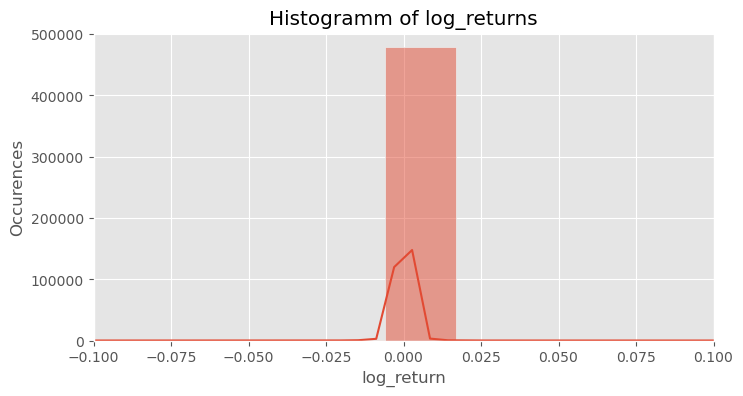

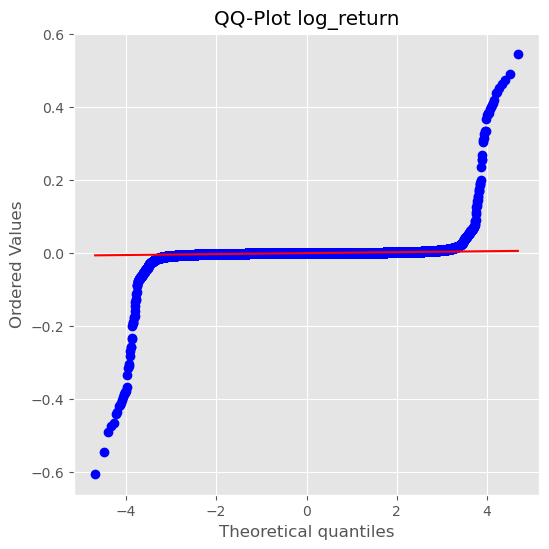

[z-Normalized Log Return]


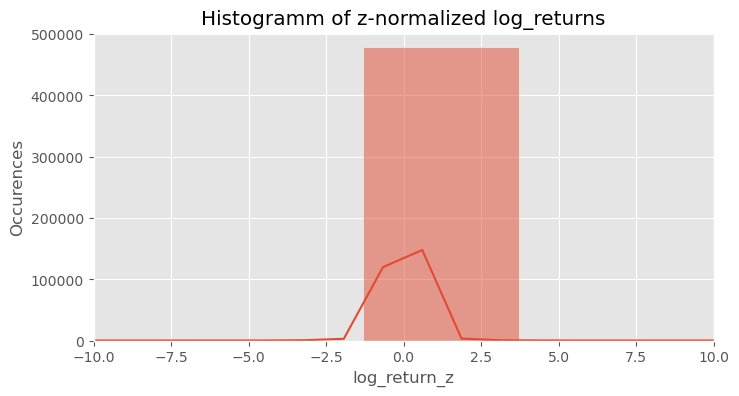

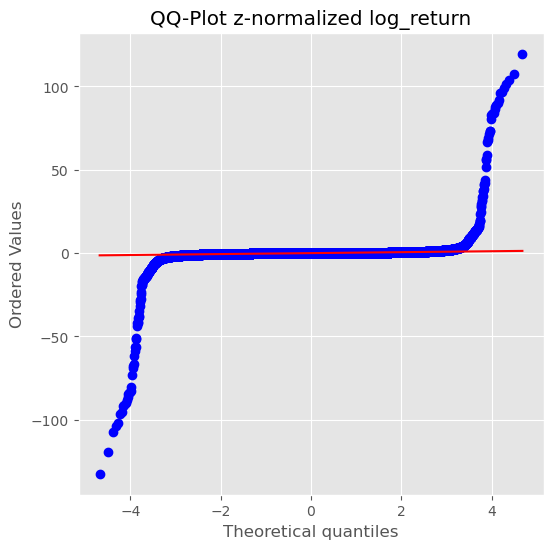

[Log Volume]


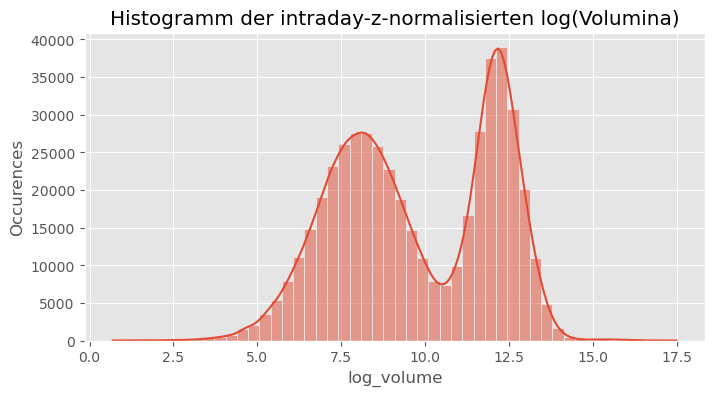

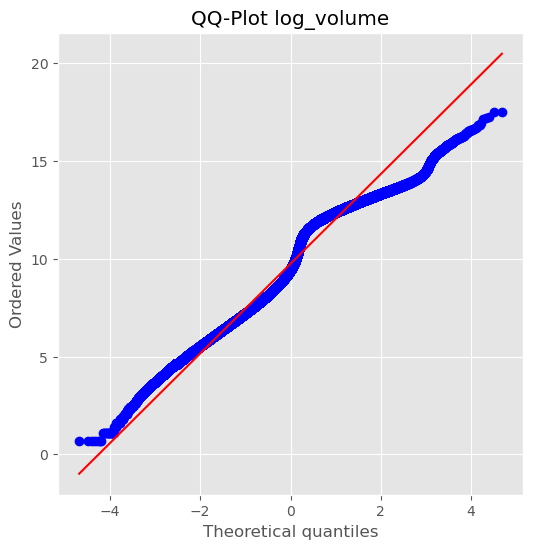

[z-Normalized Intraday Log Volume]


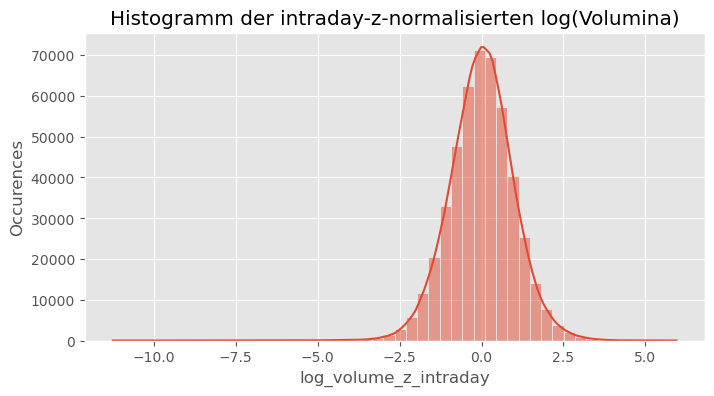

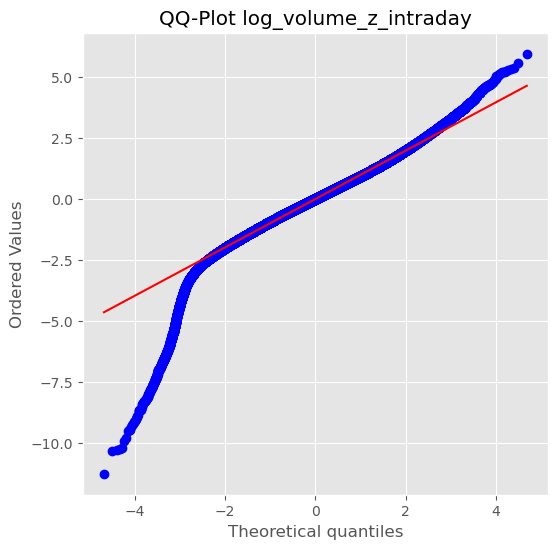

In [170]:
# Show histplot with curve of log returns and intraday z-normalized log volumes
## log_return
print("[Log Return]")
plt.figure(figsize=(8, 4))
sns.histplot(df_stock_data['log_return'].dropna(), bins=50, kde=True)
plt.title('Histogramm of log_returns')
plt.xlabel('log_return')
plt.xlim([-0.1, 0.1])
plt.ylabel('Occurences')
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(df_stock_data['log_return'].dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot log_return')
plt.show()

## log_return_z
print("[z-Normalized Log Return]")
plt.figure(figsize=(8, 4))
sns.histplot(df_stock_data['log_return_z'].dropna(), bins=50, kde=True)
plt.title('Histogramm of z-normalized log_returns')
plt.xlabel('log_return_z')
plt.xlim([-10, 10])
plt.ylabel('Occurences')
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(df_stock_data['log_return_z'].dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot z-normalized log_return')
plt.show()

## log_volume --> not normally distributed, so we use the z-normalized version
print("[Log Volume]")
### Histogram 
plt.figure(figsize=(8, 4))
sns.histplot(df_stock_data['log_volume'].dropna(), bins=50, kde=True)
plt.title('Histogramm der intraday-z-normalisierten log(Volumina)')
plt.xlabel('log_volume')
plt.ylabel('Occurences')
plt.show()

# QQ-Plot to check for normal distribution
plt.figure(figsize=(6, 6))
stats.probplot(df_stock_data['log_volume'].dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot log_volume')
plt.show()

## log_volume_z_intraday
print("[z-Normalized Intraday Log Volume]")
### Histogram 
plt.figure(figsize=(8, 4))
sns.histplot(df_stock_data['log_volume_z_intraday'].dropna(), bins=50, kde=True)
plt.title('Histogramm der intraday-z-normalisierten log(Volumina)')
plt.xlabel('log_volume_z_intraday')
plt.ylabel('Occurences')
plt.show()

# QQ-Plot to check for normal distribution
plt.figure(figsize=(6, 6))
stats.probplot(df_stock_data['log_volume_z_intraday'].dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot log_volume_z_intraday')
plt.show()



<Axes: xlabel='tweet_emotion', ylabel='count'>

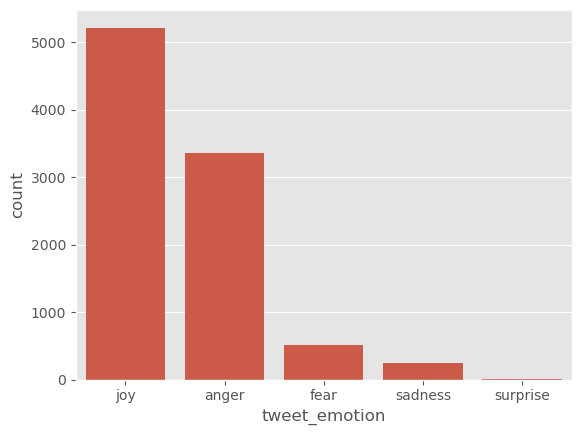

In [171]:
# Data exploration
## Emotion Occurrence
sns.countplot(x='tweet_emotion', data=df_tweets_normalized)

<h3>[Event Study]</h3>
<p>
1. Data Preparation (Tweet Data): Grouping tweets to events and assigning a weighted event emotion.
</p>
<ul>
    <li>Filter stock data by market hours</li>
    <li>Group tweets with diff < 7h to an event</li>
    <li>Assign weighed event emotions based on engagement</li>
</ul>

In [172]:
# 1. Filter out tweets outside market hours (+-2h)
df_tweets_normalized = df_tweets_normalized[
    df_tweets_normalized['timestamp'].dt.time >= pd.to_datetime("04:00").time()
]
df_tweets_normalized = df_tweets_normalized[
    df_tweets_normalized['timestamp'].dt.time <= pd.to_datetime("17:59").time()
]

# 2. Sort by time
df_tweets_normalized = df_tweets_normalized.sort_values("timestamp").reset_index(drop=True)

# 3. Compute time difference between tweets
df_tweets_normalized['time_diff'] = df_tweets_normalized['timestamp'].diff()

# 4. Cluster Tweets to events with time_diff >= 7h
df_tweets_normalized['new_event'] = df_tweets_normalized['time_diff'] > pd.Timedelta(hours=7)

# 5. Cumulate events in event_id
df_tweets_normalized['event_id'] = df_tweets_normalized['new_event'].cumsum()

# 6. Compute the dominant emotion for each event and merge back to df
def compute_event_emotion(group):
    total_engagement = group['engagement'].sum()
    weighted_emo_scores = {
        emotion: (group[emotion] * group['engagement']).sum() / total_engagement
        for emotion in ekman_emotions
    }
    event_emotion = max(weighted_emo_scores, key=weighted_emo_scores.get)
    return pd.Series({
        **weighted_emo_scores,
        'event_emotion': event_emotion
    })

if not ('event_emotion' in df_tweets_normalized.columns):
    df_event_emotions = (df_tweets_normalized
        .drop(columns=['event_id'])
        .groupby(df_tweets_normalized['event_id'], group_keys=False)
        .apply(compute_event_emotion)
        .reset_index()
    )

    df_tweets_normalized = (df_tweets_normalized
        .merge(
            df_event_emotions[['event_id', 'event_emotion']],
            on='event_id',
            how='left'
        )
        .drop(columns={'anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise', 'tweet_emotion', 'new_event'})
    )
df_tweets_normalized.head()

# 8. Set event from time to time of the earliest tweet (models from what point in time a reaction can occur)
df_tweets_normalized['event_time'] = df_tweets_normalized.groupby('event_id')['timestamp'].transform('min')

# 9. Filter duplicate events
df_tweets_normalized = df_tweets_normalized.drop_duplicates(subset=['event_id'])

print("[Info] Number of events = ", df_tweets_normalized['event_id'].nunique(), "\n")

[Info] Number of events =  691 



<p>2. Align dataframes</p>
<p>In this step, the event data is processed as follows:</p>
<ul>
    <li>Event timestamps are aligned with the subsequent stock data timestamp. Hence, they are rounded and assigned to the next full minute.</li>
    <li>Events that do not have a full 5h history of estimation trading data are sorted out.</li>
    <li>Events that do not have a full 2h event window of trading data ahead are sorted out.</li>
    <li>Events, whose estimation or event window exceed the trading day, are sorted out (in alignment to the previous two points).</li>
</ul>

In [174]:
# 0. Create new dfs with necessary event data and set time column as index
df_events = (df_tweets_normalized[['event_id', 'event_emotion', 'event_time']]
             .set_index('event_time')
             .sort_index())
df_trades = (df_stock_data[['timestamp', 'log_return', 'log_return_z', 'log_volume', 'log_volume_z_intraday']]
              .set_index('timestamp')
              .sort_index())
df_trades.head()

,log_return,log_return_z,log_volume,log_volume_z_intraday
timestamp,,,,
2023-05-01 04:00:00-04:00,NaN,NaN,8.416046,-1.112136
2023-05-01 04:01:00-04:00,0.000122,0.026335,7.965893,-1.216433
2023-05-01 04:03:00-04:00,-0.001946,-0.425941,6.876265,-1.764073
2023-05-01 04:04:00-04:00,-0.000792,-0.173422,4.615121,-3.658253
2023-05-01 04:05:00-04:00,-0.002745,-0.600761,7.824446,-0.764483


In [175]:
# 1. Filter events based on overlaps, estimation and observation windows
# 2. Calculate expected and abnormal returns for each event
def filter_events(df, get_pre = 0):
    # Define necessary vars
    est = 300
    obs = 120
    gap = est + obs
    results = []

    # 1. Filter by Overlaps
    valid_events = []
    last_event = None

    # Add valid events to the list
    for date in df.index:
        # First event always valid
        if last_event is None:
            valid_events.append(date)
            last_event = date
        else:
            # If timeshift > gaps, keep the current event and set as new last_event
            if (date - last_event) > pd.Timedelta(minutes=gap):
                valid_events.append(date)
                last_event = date

    # Only keep valid events
    df = df.loc[valid_events]
    print(f"[Overlap] New df_length = {len(df)}")

    # 2. Align event_time with the next available trading timestamp
    df.index = df.index.tz_convert(eastern)

    for i, date in enumerate(df.index):
        if date not in df_trades.index:
            future_times = df_trades.index[df_trades.index > date]
            if not future_times.empty:
                df.index.values[i] = pd.Timestamp(future_times[0])

    # 3. Filter events without sufficient estimation_window data
    # 4. Filter events without sufficient event_window data
    valid_events = []

    for date in df.index:
        day_data = df_trades[df_trades.index.date == date.date()]
        event_index = day_data.index.get_loc(date)

        remaining = len(day_data) - event_index

        if event_index >= est:
            if remaining >= obs:
                valid_events.append(date)

    df = df.loc[valid_events]
    print(f"[Sum Data] New df_length = {len(df)}")

    # 5. Event study variables
    for event_row in df.itertuples():
        event_id = event_row.event_id
        event_emo = event_row.event_emotion
        event_time = event_row.Index

        estimation_window = df_trades.loc[
            event_time - pd.Timedelta(minutes=est) : event_time - pd.Timedelta(minutes=1)
        ]
        event_window = df_trades.loc[
            event_time - pd.Timedelta(minutes=get_pre * est): event_time + pd.Timedelta(minutes=obs - 1)
        ]

        expected_return = estimation_window['log_return'].mean()
        expected_volume = estimation_window['log_volume'].mean()
        expected_volume_z_intraday = estimation_window['log_volume_z_intraday'].mean()

        for i, fin_row in enumerate(event_window.itertuples()):
            if get_pre == 1:
                i = int((fin_row.Index - event_time).total_seconds() // 60)

            actual_return = fin_row.log_return
            abnormal_return = actual_return - expected_return

            actual_volume = fin_row.log_volume
            abnormal_volume = actual_volume - expected_volume

            actual_volume_z_intraday = fin_row.log_volume_z_intraday
            abnormal_volume_z_intraday = actual_volume_z_intraday - expected_volume_z_intraday

            results.append({
                'event_id': event_id,
                'event_fin_offset': i,
                'event_time': event_time,
                'fin_time': fin_row.Index,
                'event_emo': event_emo,
                'actual_return': actual_return,
                'expected_return': expected_return,
                'abnormal_return': abnormal_return,
                'actual_volume': actual_volume,
                'expected_volume': expected_volume,
                'abnormal_volume': abnormal_volume,
                'actual_volume_z_intraday': actual_volume_z_intraday,
                'expected_volume_z_intraday': expected_volume_z_intraday,
                'abnormal_volume_z_intraday': abnormal_volume_z_intraday
            })

    # Make a dataframe from the result list
    df_valid_events = pd.DataFrame(results)

    return df_valid_events

df_event_study = filter_events(df_events, get_pre = 0)
df_event_study_pre_post = filter_events(df_events, get_pre=1)

[Overlap] New df_length = 691


C:\Users\aklei\AppData\Local\Temp\ipykernel_48908\444423743.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  df.index.values[i] = pd.Timestamp(future_times[0])


[Sum Data] New df_length = 317
[Overlap] New df_length = 691


C:\Users\aklei\AppData\Local\Temp\ipykernel_48908\444423743.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  df.index.values[i] = pd.Timestamp(future_times[0])


[Sum Data] New df_length = 317


In [176]:
df_event_study.head() 

,event_id,event_fin_offset,event_time,fin_time,event_emo,actual_return,expected_return,abnormal_return,actual_volume,expected_volume,abnormal_volume,actual_volume_z_intraday,expected_volume_z_intraday,abnormal_volume_z_intraday
0,0,0,2023-05-01 12:36:00-04:00,2023-05-01 12:36:00-04:00,joy,0.000991,-0.000061,0.001053,12.466485,10.707375,1.759110,0.899875,-0.50149,1.401365
1,0,1,2023-05-01 12:36:00-04:00,2023-05-01 12:37:00-04:00,joy,-0.000681,-0.000061,-0.000619,11.902065,10.707375,1.194690,-0.093540,-0.50149,0.407950
2,0,2,2023-05-01 12:36:00-04:00,2023-05-01 12:38:00-04:00,joy,0.000558,-0.000061,0.000620,11.642268,10.707375,0.934894,-0.497824,-0.50149,0.003666
3,0,3,2023-05-01 12:36:00-04:00,2023-05-01 12:39:00-04:00,joy,-0.001396,-0.000061,-0.001335,12.794795,10.707375,2.087420,1.546705,-0.50149,2.048194
4,0,4,2023-05-01 12:36:00-04:00,2023-05-01 12:40:00-04:00,joy,0.001210,-0.000061,0.001272,12.266965,10.707375,1.559591,0.496798,-0.50149,0.998288


[Info] Length of df_event_study: 38039 <= 38040



Text(0, 0.5, 'Number of Events (scaled)')

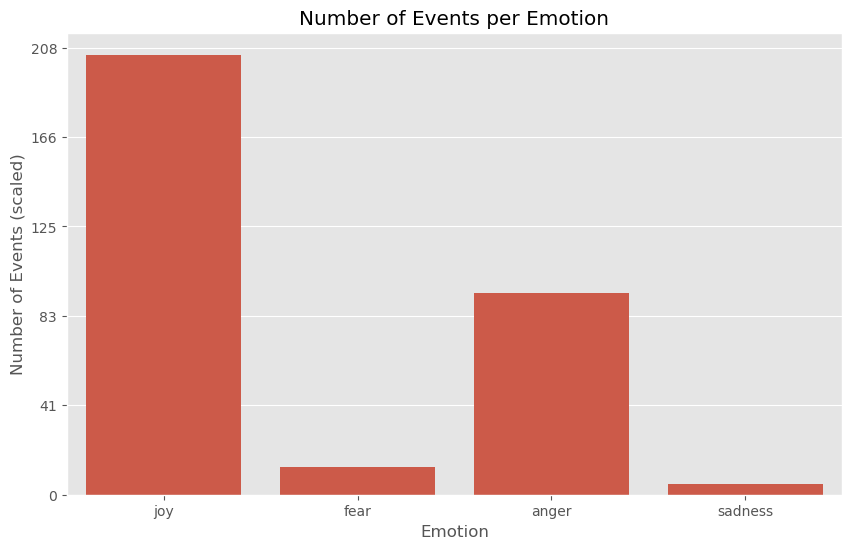

In [177]:
print(f"[Info] Length of df_event_study: {len(df_event_study)} <= {df_event_study['event_time'].nunique() * 120}\n")

def scale_formatter(x, pos):
    return f'{int(x / 120)}'

plt.figure(figsize=(10, 6))
sns.countplot(x='event_emo', data=df_event_study)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(scale_formatter))
plt.title('Number of Events per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Number of Events (scaled)')

<p><b>3.1 Abnormal Return: Investigating short term impact by offset</b></p>
<p>[Intro]</p>
<p>In the following it is analysed to what extent a significant effect of a particular emotion on the change in stock return can be observed by the minute<br>
--> Is the mean abnormal return significantly greater / lower than 0 resp. does the mean abnormal return significantly differ from the expected return?</p>
<p>
    <ul>
        <li>H0: mean abnormal return = 0</li>
        <li>H1: mean abnormal return >< 0</li>
    </ul>
</p>

In [178]:
from scipy import stats

print(f"[Info] Testing for significant effect of emotions {df_event_study['event_emo'].unique()} on abnormal returns ...")

# Format significance stars
def stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''
    
def test_abnormal_values(df, test_col):
    results = []

    emotions = df['event_emo'].unique()
    minutes = df['event_fin_offset'].unique()

    for minute in minutes:
        row = {'minute': minute}

        for emo in emotions:
            values = df.loc[
                (df['event_fin_offset'] == minute) & (df['event_emo'] == emo),
                test_col
            ]
            if len(values) > 1:
                t_stat, p_value = stats.ttest_1samp(values, 0)
                row[f'{emo}_{test_col}_mean'] = values.mean()
                row[f'{emo}_{test_col}_t_stat'] = t_stat
                row[f'{emo}_{test_col}_p_value'] = p_value
                row[f'{emo}_{test_col}_sig'] = f"{t_stat:.2f}{stars(p_value)}"
            else:
                row[f'{emo}_{test_col}_mean'] = np.nan
                row[f'{emo}_{test_col}_t_stat'] = np.nan
                row[f'{emo}_{test_col}_p_value'] = np.nan
                row[f'{emo}_{test_col}_sig'] = ''
        
        results.append(row)
    return pd.DataFrame(results)

# Test returns
ar_test_scores = test_abnormal_values(df_event_study, 'abnormal_return')
ar_test_scores.set_index('minute', inplace=True)

# Show only rows with significant p-values
alpha = 0.05

pval_cols = [col for col in ar_test_scores.columns if col.endswith('_p_value')]
# At least one significant p-value in the row
significant_rows = ar_test_scores[(ar_test_scores[pval_cols] < alpha).any(axis=1)]
sig_cols = [col for col in significant_rows.columns if col.endswith('_sig')]
significant_rows[sig_cols]

[Info] Testing for significant effect of emotions ['joy' 'fear' 'anger' 'sadness'] on abnormal returns ...


,joy_abnormal_return_sig,fear_abnormal_return_sig,anger_abnormal_return_sig,sadness_abnormal_return_sig
minute,,,,
1,-2.21**,-1.13,-0.44,-0.78
27,-0.86,3.98***,0.25,-0.15
34,-1.30,-0.80,-3.74***,-0.89
56,1.63,2.34**,-1.15,0.55
61,2.01**,-0.39,2.50**,0.20
67,1.15,-2.52**,1.73*,-0.99
79,-2.03**,-0.90,-0.91,0.93
100,-1.63,-0.77,2.42**,1.34
101,-1.11,-0.94,-2.06**,-0.50


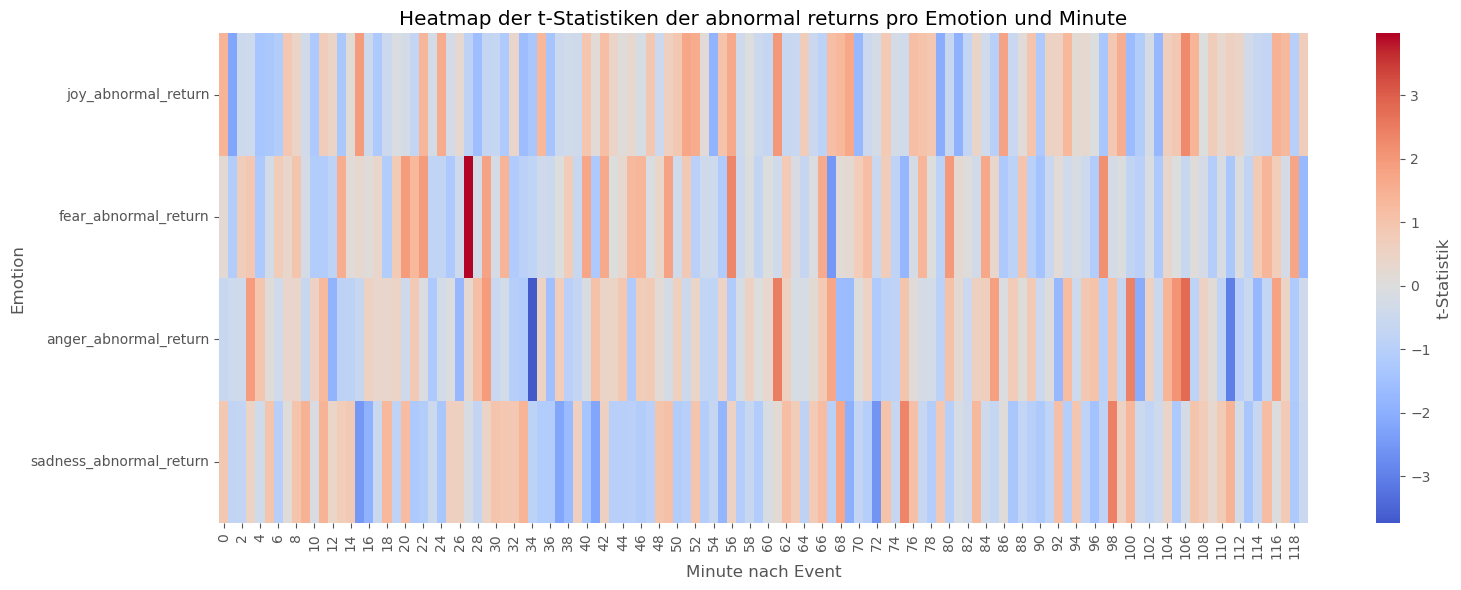

In [ ]:
# Emotionen extrahieren (alle Spalten mit '_t_stat' am Ende)
emotions = [col.replace('_t_stat', '') for col in ar_test_scores.columns if col.endswith('_t_stat')]

# DataFrame für Heatmap vorbereiten: Zeilen = Emotionen, Spalten = Minuten
heatmap_data = pd.DataFrame({
    emo: ar_test_scores[f"{emo}_t_stat"] for emo in emotions
}).T  # Transponieren: Emotionen als Zeilen

plt.figure(figsize=(16, 6))
sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    center=0,
    annot=False,
    cbar_kws={'label': 't-Statistik'}
)
plt.xlabel("Minute nach Event")
plt.ylabel("Emotion")
plt.title("Heatmap der t-Statistiken der abnormal returns pro Emotion und Minute")
plt.tight_layout()
plt.show()

<p>[Test-Results]</p>
<p><i>What was tested?</i></p>
<p>For each emotion and each minute in the post-event window it was tested if the mean abnormal return significantly deviates from 0. The goal was to detect whether there is a deviation from the expected return (H0: mean = 0).</p>
<p><i>Results</i></p>
<p>The heatmap shows that only for few points across the emotions, a significant effect could be observed, where the mean abnormal return significantly deviates from 0. Thus, the H1: mean >< 0 can most likely be refused.
    <ul>
        <li>No consistent pattern of significant observations visible, that may indicate a recurrent effect.</li>
        <li>There are a few significant events across the heatmap. Because of their low density they can probably be declared as outliers.</li>
    </ul>
</p>
<p><i>Conclusion</i></p>
<p>In the short-term and for individual points in time, an impact of a tweets emotion on the expected return of the stock can be neglected.</p>

<p><b>3.2 Abnormal Volume: Investigating short term impact by offset</b></p>
<p>In the following it is analysed to what extent a significant effect of a particular emotion on the change in trade volume can be observed by the minute<br>
--> Is the mean abnormal volume significantly greater / lower than 0 resp. does the mean abnormal volume significantly differ from the expected volume?</p>
<p>
    <ul>
        <li>H0: mean abnormal volume = 0</li>
        <li>H1: mean abnormal volume >< 0</li>
    </ul>
</p>
<p>Here, the absolute trading volume is logarithmized for each offset. However, as volume is interesting as an absolute value (how many stocks where traded), the value is always positive and may deviate a lot. Hence, the log_volume is not normally distributed (see Illustration below) and a t-test cannot be performed as it assumes a normal distribution of the variable.</p>
<p>Consequently, a z-transformation is performed on the log_volume to be able to properly test for significance.</p>

In [181]:
# Test volumes
av_test_scores_z_intraday = test_abnormal_values(df_event_study, 'abnormal_volume_z_intraday')
av_test_scores_z_intraday.set_index('minute', inplace=True)

# Show only rows with significant p-values
alpha = 0.05

pval_cols = [col for col in av_test_scores_z_intraday.columns if col.endswith('_p_value')]
# At least one significant p-value in the row
significant_rows = av_test_scores_z_intraday[(av_test_scores_z_intraday[pval_cols] < alpha).any(axis=1)]
sig_cols = [col for col in significant_rows.columns if col.endswith('_sig')]
significant_rows[sig_cols]

,joy_abnormal_volume_z_intraday_sig,fear_abnormal_volume_z_intraday_sig,anger_abnormal_volume_z_intraday_sig,sadness_abnormal_volume_z_intraday_sig
minute,,,,
1,0.26,-1.52,-1.64,2.97**
6,0.04,-1.13,-1.31,-3.43**
8,0.35,1.06,-2.38**,-0.56
10,1.31,0.35,-2.11**,-0.05
12,0.77,1.58,0.91,-2.96**
16,-0.04,-1.74,-2.24**,-2.74*
20,-0.69,0.88,-2.07**,-1.35
29,2.06**,0.37,0.66,-1.43
39,1.36,-0.19,1.25,3.49**


<p>4. Evaluating different influences of emotions</p>
<p>In the following, the impact of each event emotion on the subsequent abnormal return / cumulative abnormal return is evaluated and visualized. The focus will be on the two dominant emotions, joy and anger.</p>

In [ ]:
def get_car_aar(df):
    # Calculate CAR and AAR
    car = df.groupby('event_fin_offset')['abnormal_return'].sum().reset_index()
    aar = df.groupby('event_fin_offset')['abnormal_return'].mean().reset_index()

    # Merge CAR and AAR
    car_aar = pd.merge(car, aar, on='event_fin_offset', suffixes=('_car', '_aar'))

    # Add event_fin_offset as a column
    car_aar['event_fin_offset'] = car_aar['event_fin_offset'].astype(int)

    return car_aar